# Purpose: Produce estimate <CH4> atmospheric lifetime and use it to combine reported emissions and emissions inferred from <CH4> data sources described at the end of this notebook.

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import csv
import xlrd
from xlrd import open_workbook
from openpyxl import Workbook
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17CH4')

Read two input files separately and assign the year values and methane concentration data

In [2]:
df1 = pd.read_excel('v432_CH4_1970_2012.xls','v4.3.2_EM_CH4')
df1.to_csv('v432_CH4 _1970_2012.csv',header=False,index=False)
df1 = pd.read_csv('v432_CH4 _1970_2012.csv')

df2 = pd.read_excel('v432_CH4_1970_2012.xls','TOTALS BY COUNTRY')
df2.to_csv('TOTALS BY COUNTRY.csv',header=False,index=False)
df2 = pd.read_csv('TOTALS BY COUNTRY.csv')

df4 = pd.read_excel('heat17-ch4-1-2017dec14.xlsx')
df4.to_csv('heat17-ch4-1-2017dec14.csv',header=False,index=False)
df4 = pd.read_csv('heat17-ch4-1-2017dec14.csv')
df4.drop(df4.index[[-1]],inplace=True)
# print (df4)

In [3]:
out1 = 'heat'
out2 = 'ch4emit'
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-') # split the date string we create by symbol "-"
yrs = str(int(date_split[0])-2000) # real years minus 2000 
seq = [out1, yrs, out2,months[int(date_split[1])-1],date_split[2]]
seperator = ','
filename = seperator.join(seq).replace(',', '')
print (filename)

heat18ch4emitjul12


Assemble Data

Emissions Data

0     1970
1     1971
2     1972
3     1973
4     1974
5     1975
6     1976
7     1977
8     1978
9     1979
10    1980
11    1981
12    1982
13    1983
14    1984
15    1985
16    1986
17    1987
18    1988
19    1989
20    1990
21    1991
22    1992
23    1993
24    1994
25    1995
26    1996
27    1997
28    1998
29    1999
30    2000
31    2001
32    2002
33    2003
34    2004
35    2005
36    2006
37    2007
38    2008
39    2009
40    2010
41    2011
42    2012
Name: 0, dtype: object
Unnamed: 6     266.099581
Unnamed: 7     275.813505
Unnamed: 8     284.351780
Unnamed: 9     300.081619
Unnamed: 10    302.598475
Unnamed: 11    298.030333
Unnamed: 12    311.719321
Unnamed: 13    310.683298
Unnamed: 14    318.609033
Unnamed: 15    315.709341
Unnamed: 16    308.702040
Unnamed: 17    292.750700
Unnamed: 18    292.800437
Unnamed: 19    290.647024
Unnamed: 20    289.558977
Unnamed: 21    290.955770
Unnamed: 22    292.466318
Unnamed: 23    291.144128
Unnamed: 24    300.807085
Unnamed: 2

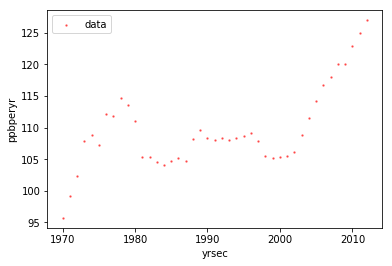

In [4]:
yrsec = df1.iloc[0,6:49]
yrsec.index = np.arange(0, len(yrsec))
print (yrsec)
df2 = df2.iloc[1:]  # ecall = df2
df2 = df2.fillna(0) # replace all the NaN values with Zero's in a pandas dataframe
df2.index = np.arange(0, len(df2))

ecbycontryraw = [] 
for i in range(0,len(df2)):
    sub_list=[]
    for m in range(6,len(df2.columns)):
        x = df2.iloc[i,m].tolist()
        sub_list.append(float(x))
    ecbycontryraw.append(sub_list)
  
giggatonneperyr = df2.iloc[:, 6:len(df2.columns)].sum(axis=0)/1000
ppbperyr = giggatonneperyr /2.78
ppbperyr.index = np.arange(0, len(ppbperyr))
# ppbperyr=ppbperyr.tolist()
print (giggatonneperyr)

df3 = pd.concat([yrsec, ppbperyr], axis=1).reset_index()
df3 = df3.drop('index',axis=1)
df3.columns = ['yrsec','ppbperyr']

print (df3)
df3 = df3.astype(float) # Cast a pandas object to a specified dtype float.
df3.plot.scatter(x='yrsec',y='ppbperyr',s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
                           

CH4 Data and Finite Differences

In [5]:
yrs2 = df4['Julian']
yrs2 = yrs2.iloc[1:-1]
print (type(yrs2))

ch4 = df4.iloc[:,1:2]
ch4 = ch4['ppb'].tolist()
ch4 = list(map(float, ch4))
# del record[-1]
# print (ch4[0])

dch4dt = []

for i in range(0,len(ch4)-1):
#     sub_list=[]
    if i == 0:
        x = ch4[1]-ch4[0]
        dch4dt.append(float(x))
    else:
        x = (ch4[i+1]-ch4[i-1])/2
        dch4dt.append(float(x))

print (len(dch4dt))

ch40 = 732.138


b0 = dch4dt[int(yrsec.iloc[-1])-1]
print (b0)



index = list(range(int(yrsec.iloc[0])-1, int(yrsec.iloc[-1])))

c0 = [ dch4dt[i] for i in index]

c1 = [ ch4[i] for i in index]

print(len(c1))
ppbperyr = df3['ppbperyr'].tolist()
ppbperyr = list(map(float, ppbperyr))


l1 = [ppbperyr[i]-c0[i] for i in range(0,len(c0))]






<class 'pandas.core.series.Series'>
2016
5.149999999999977
43


In [6]:
def err(d0,lifetofind):
    y = (d0 - ch40)/lifetofind
    return y
param_bounds=(0,50)
popt, pcov = curve_fit(err, c1, l1, bounds=param_bounds)
print (popt)

[9.45659209]


In [7]:
tlastpre = 1749
del ch4[-1]
x = np.array(ch4)
fit = err(x, *popt)
emitlate = fit + dch4dt
emitlate = emitlate[tlastpre:] 

yrs2 = yrs2.tolist()
yrs2 = list(map(int, yrs2))
yrslate = yrs2[tlastpre:] 

itemindex = yrslate.index(int(yrsec[0]))

rescale = ppbperyr[0]/emitlate[itemindex]
print (rescale)
print (emitlate[itemindex])
print(ppbperyr[0])

1.0642351977561217
89.9418418170973
95.71927381276836
